In [1]:
from skimage import io,filters, morphology, measure, draw,exposure
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import trackpy as tp
import pandas as pd
from scipy.stats import median_abs_deviation
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity
from skimage.filters import threshold_otsu
import seaborn as sns
import sys
sys.path.insert(1, '<PATH/TO/DIR>/WAVE/')
import identify_rings as idr
import warnings
warnings.filterwarnings('ignore')

In [2]:
PATH = '<PATH/TO/DIR>/WAVE/Fig2_FigS2CD_Hem1KO/'

In [3]:
def f_linear(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B



# Quantification of the mean unit length intensity of the WAVE complex nanorings

In [4]:
image = io.imread(PATH + 'example_images/240522_PMW7_LATB_SIM_1-4_SIR.tif')

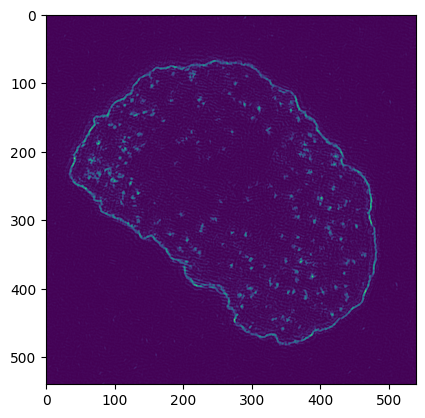

In [5]:
plt.imshow(image[0])

In [6]:
threshold_otsu(image)

192.7204

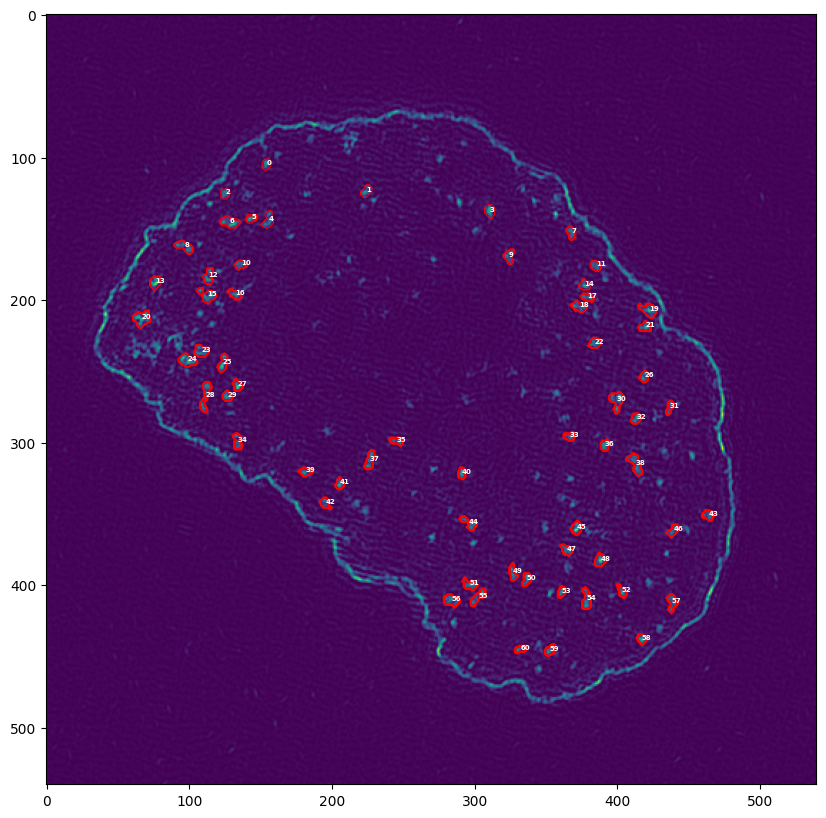

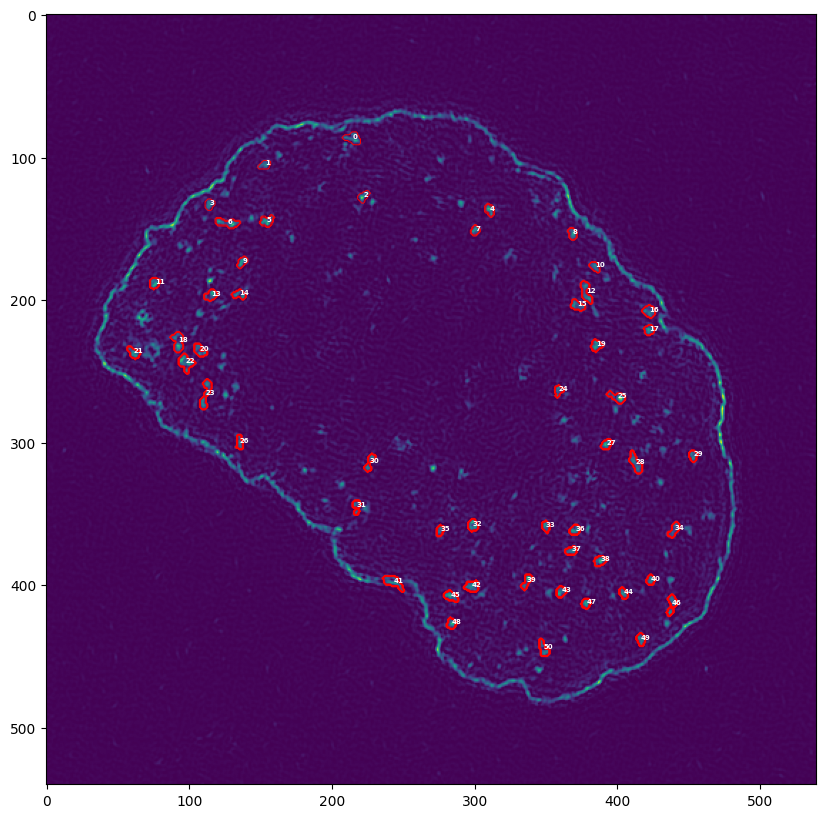

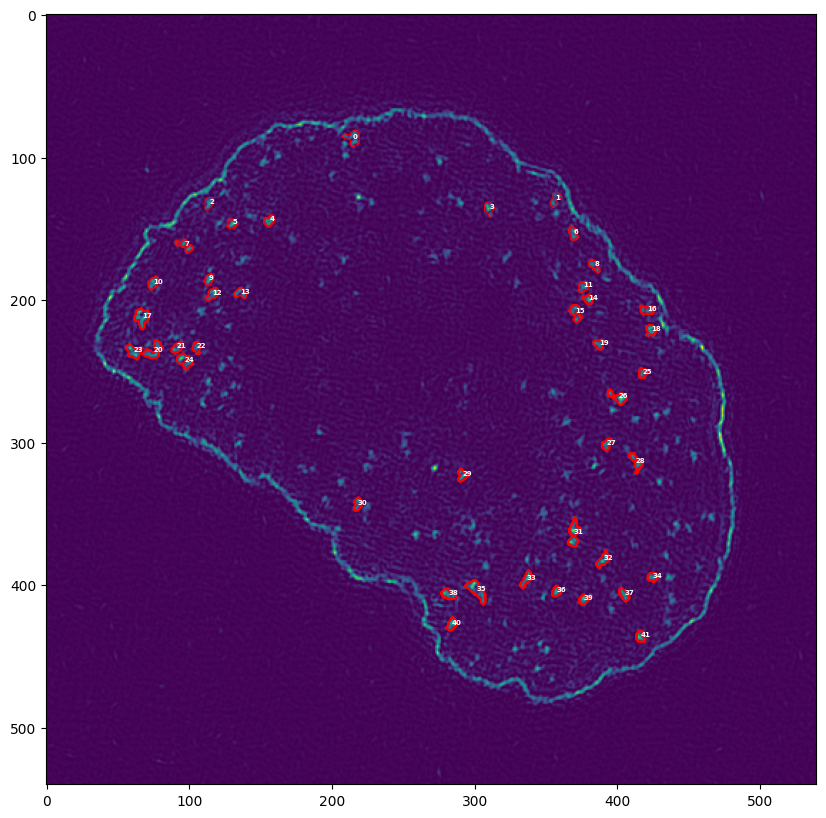

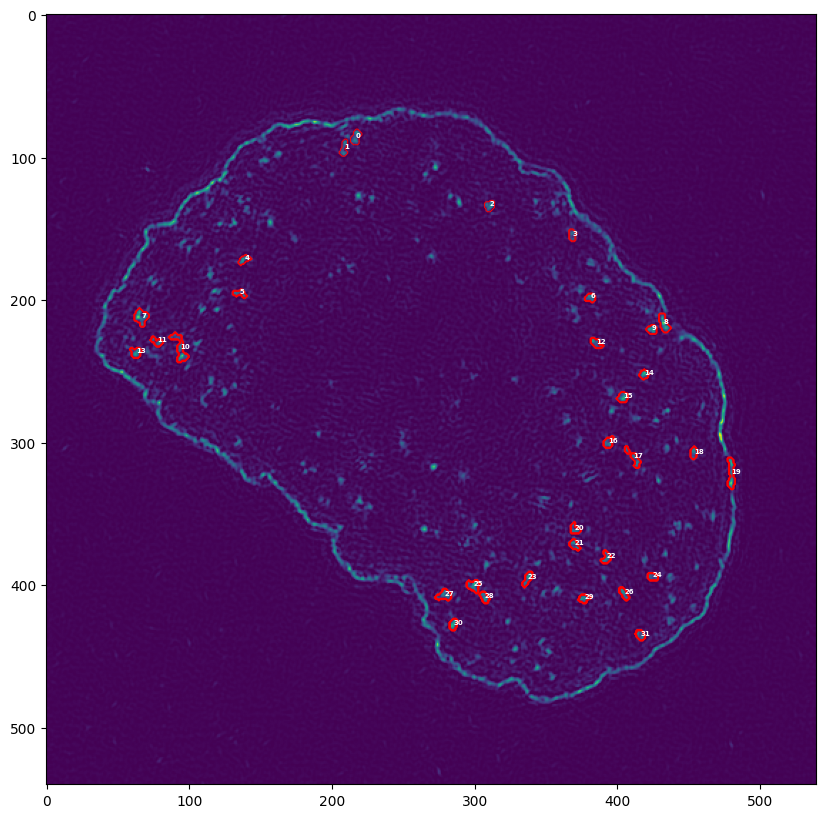

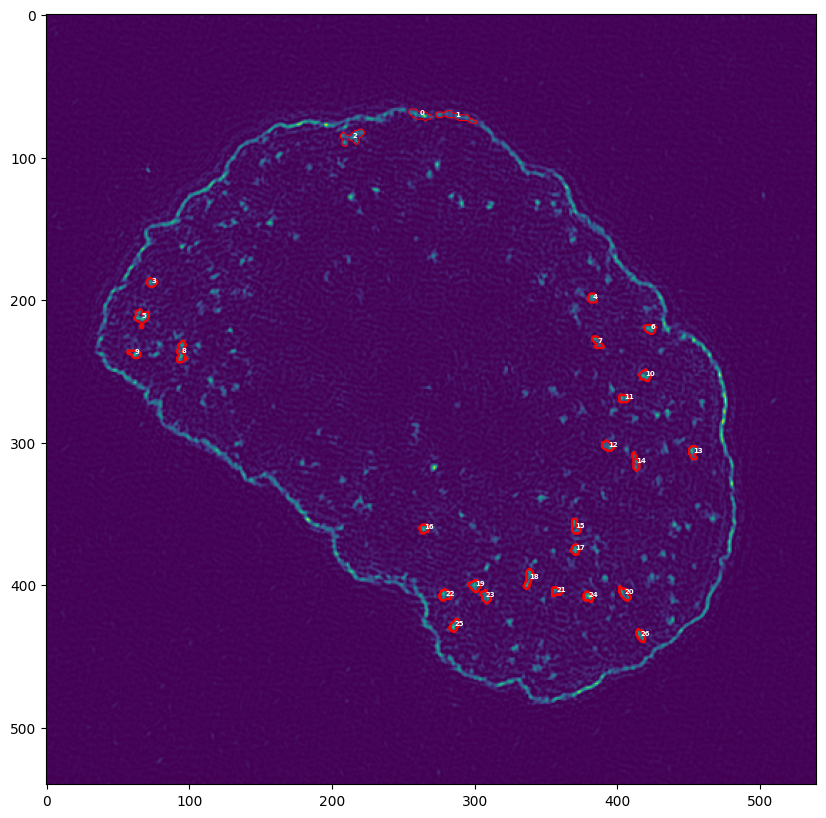

In [7]:
rings = pd.DataFrame()
opt_threshold = 155
for i in range(image.shape[0]):
    prop, label_mask_clean = idr.seg_cells(image[i], opt_threshold, 1.2, 30, 100, True)
    features = pd.DataFrame()
    for j in range(len(prop)): 
        y_center, x_center = prop[j].centroid # note that image coordinates are often given as (y, x) rather than (x, y)
        plt.text(x_center, y_center, str(j), fontweight = 'bold', color = 'white',size = 5)

        features = features.append([{'label':prop[j].label,'x': prop[j].centroid[0],
                                     'y': prop[j].centroid[1],'length': prop[j].major_axis_length,'frame': i}])
    results = idr.ring_fitting(image[i], label_mask_clean, features, 8, 0.7, False)
    if "intensity" in results:
        rings = rings.append(results[results.intensity>0])
rings['final_intensity'] = rings['intensity'] - rings['background']
rings['unit_intensity'] = rings['final_intensity']/rings['perimeter']

In [8]:
mean_unit_intensity = rings['unit_intensity'].mean()
mean_unit_intensity

468.9964305590002

# Quantification of the Hem1-eGFP expression level

In [9]:
image_epi = io.imread(PATH + 'example_images/240522_PMW7_LATB_EPI_1-4.tif')

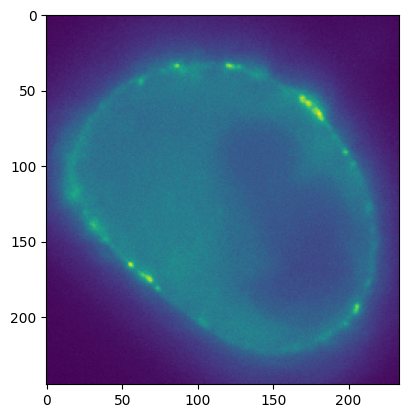

In [10]:
plt.imshow(image_epi[3])

In [11]:
thres = threshold_otsu(image_epi)
thres

751

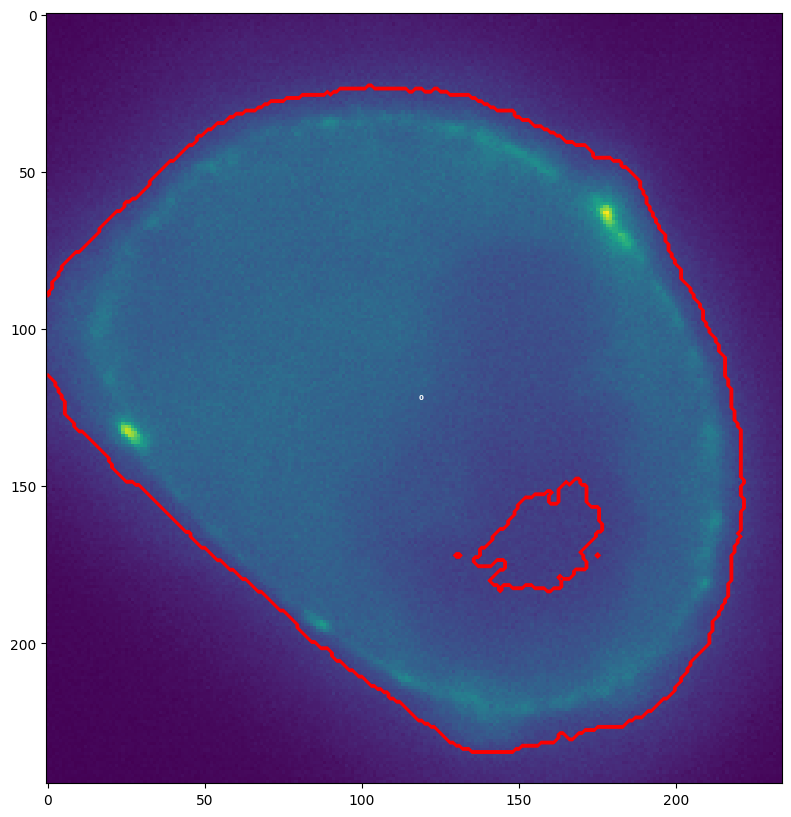

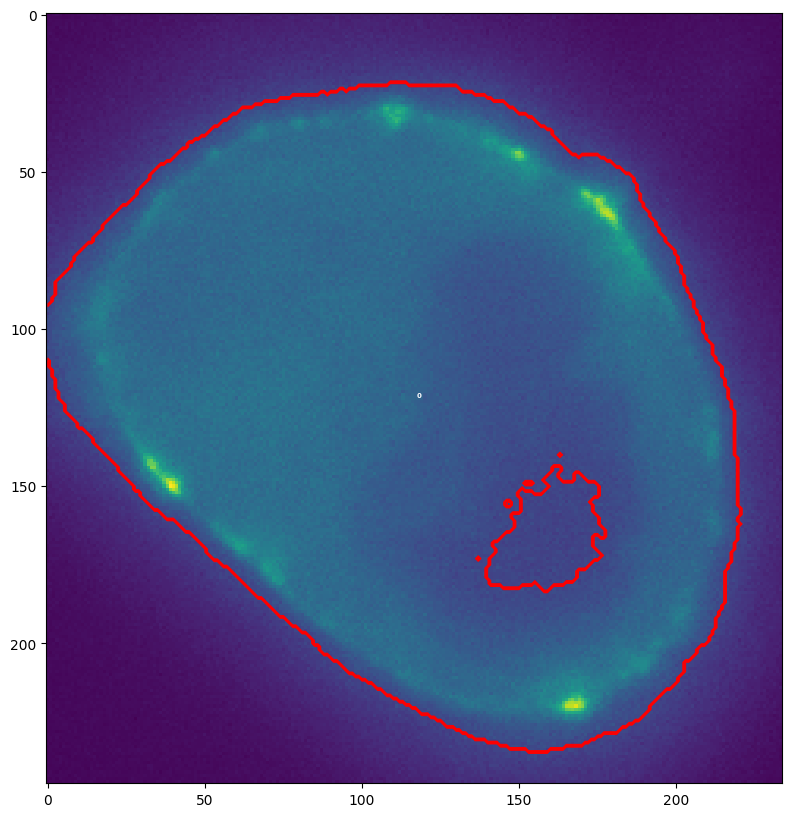

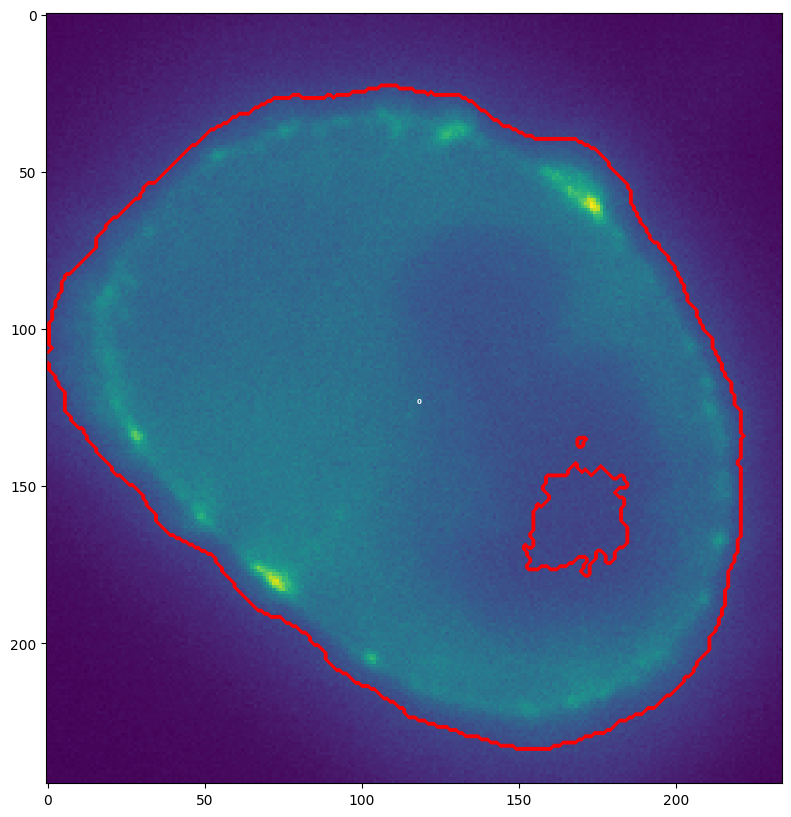

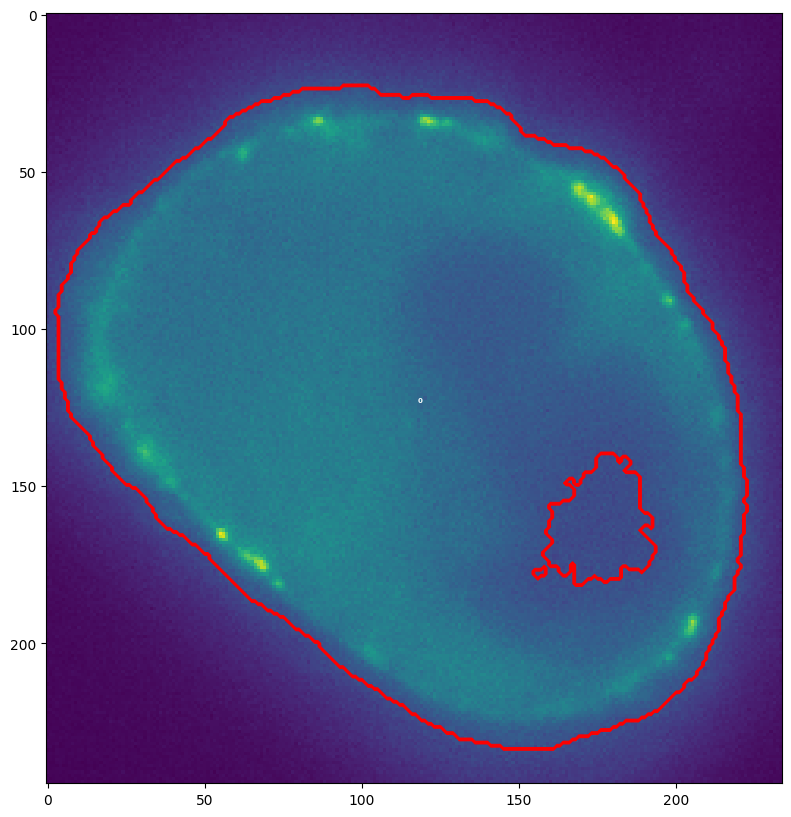

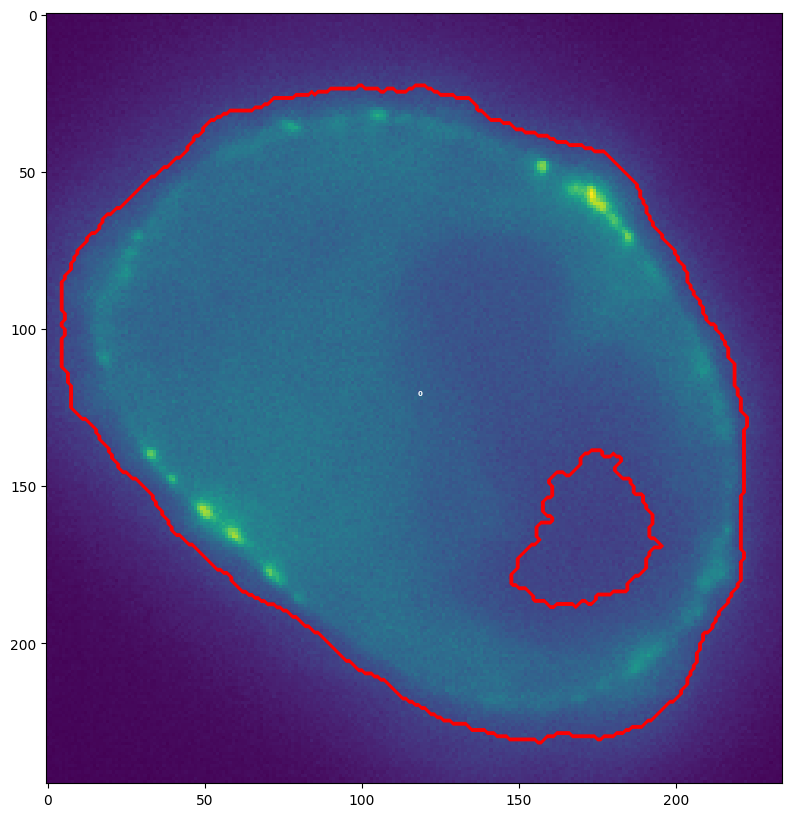

In [12]:
features = pd.DataFrame()
for i in range(5):
    prop,label_mask_clean = idr.seg_cells(image_epi[i],thres,1.2,10000,120000,True)
    
    for j in range(len(prop)): 
        y_center, x_center = prop[j].centroid # note that image coordinates are often given as (y, x) rather than (x, y)
        plt.text(x_center, y_center, str(j), fontweight = 'bold', color = 'white',size = 5)

        features = features.append([{'label':prop[j].label,'x': prop[j].centroid[0],
                                 'y': prop[j].centroid[1],'frame': i,
                                    'area':prop[j].area,'intensity':prop[j].intensity_mean}])
epi_intens = features.intensity.mean()

In [13]:
epi_intens

1079.9380317706186

# Generate plots

In [14]:
exp_level = pd.read_csv(PATH + 'csv_data/rings_expression_level.csv')

In [15]:
rings_intens = pd.read_csv(PATH + 'csv_data/rings_unit_length_intensity.csv')

In [16]:
selected_epi = ['240522_PMW7_LATB_EPI_1-2.tif','240522_PMW7_LATB_EPI_3-2.tif','240522_PMW7_LATB_EPI_2-2.tif',
           '240522_PMW7_LATB_EPI_2-15.tif','240522_PMW7_LATB_EPI_2-6.tif','240522_PMW7_LATB_EPI_3-3.tif']

In [17]:
select_exp = exp_level[exp_level.cells.isin(selected_epi)]


In [18]:
select_exp = select_exp.sort_values('exp_level')

In [19]:
select_exp

exp_level                          cells
45   439.601152   240522_PMW7_LATB_EPI_1-2.tif
28   625.570996   240522_PMW7_LATB_EPI_2-2.tif
41   704.014880  240522_PMW7_LATB_EPI_2-15.tif
32   897.016667   240522_PMW7_LATB_EPI_2-6.tif
55  1149.905375   240522_PMW7_LATB_EPI_3-2.tif
56  1455.193658   240522_PMW7_LATB_EPI_3-3.tif

In [20]:
selected_ring = ['240522_PMW7_LATB_SIM_1-2_SIR.tif','240522_PMW7_LATB_SIM_2-2_SIR.tif','240522_PMW7_LATB_SIM_2-15_SIR.tif',
            '240522_PMW7_LATB_SIM_2-6_SIR.tif','240522_PMW7_LATB_SIM_3-2_SIR.tif','240522_PMW7_LATB_SIM_3-3_SIR.tif']

In [21]:
select_ring = rings_intens[rings_intens.cells.isin(selected_ring)]

In [22]:
select_ring = select_ring.reindex(index=[45,28,41,32,55,56])

In [23]:
select_ring


rings_intens                              cells
45    335.538023   240522_PMW7_LATB_SIM_1-2_SIR.tif
28    430.722856   240522_PMW7_LATB_SIM_2-2_SIR.tif
41    399.964669  240522_PMW7_LATB_SIM_2-15_SIR.tif
32    428.873487   240522_PMW7_LATB_SIM_2-6_SIR.tif
55    432.174492   240522_PMW7_LATB_SIM_3-2_SIR.tif
56    516.352483   240522_PMW7_LATB_SIM_3-3_SIR.tif

In [24]:
popt = curve_fit(f_linear,exp_level['exp_level'],rings_intens['rings_intens'])[0]

In [25]:
cmap = plt.cm.get_cmap('Greens')
palette = cmap(np.linspace(0.3, 0.8, 6))

In [26]:
len(exp_level)

58

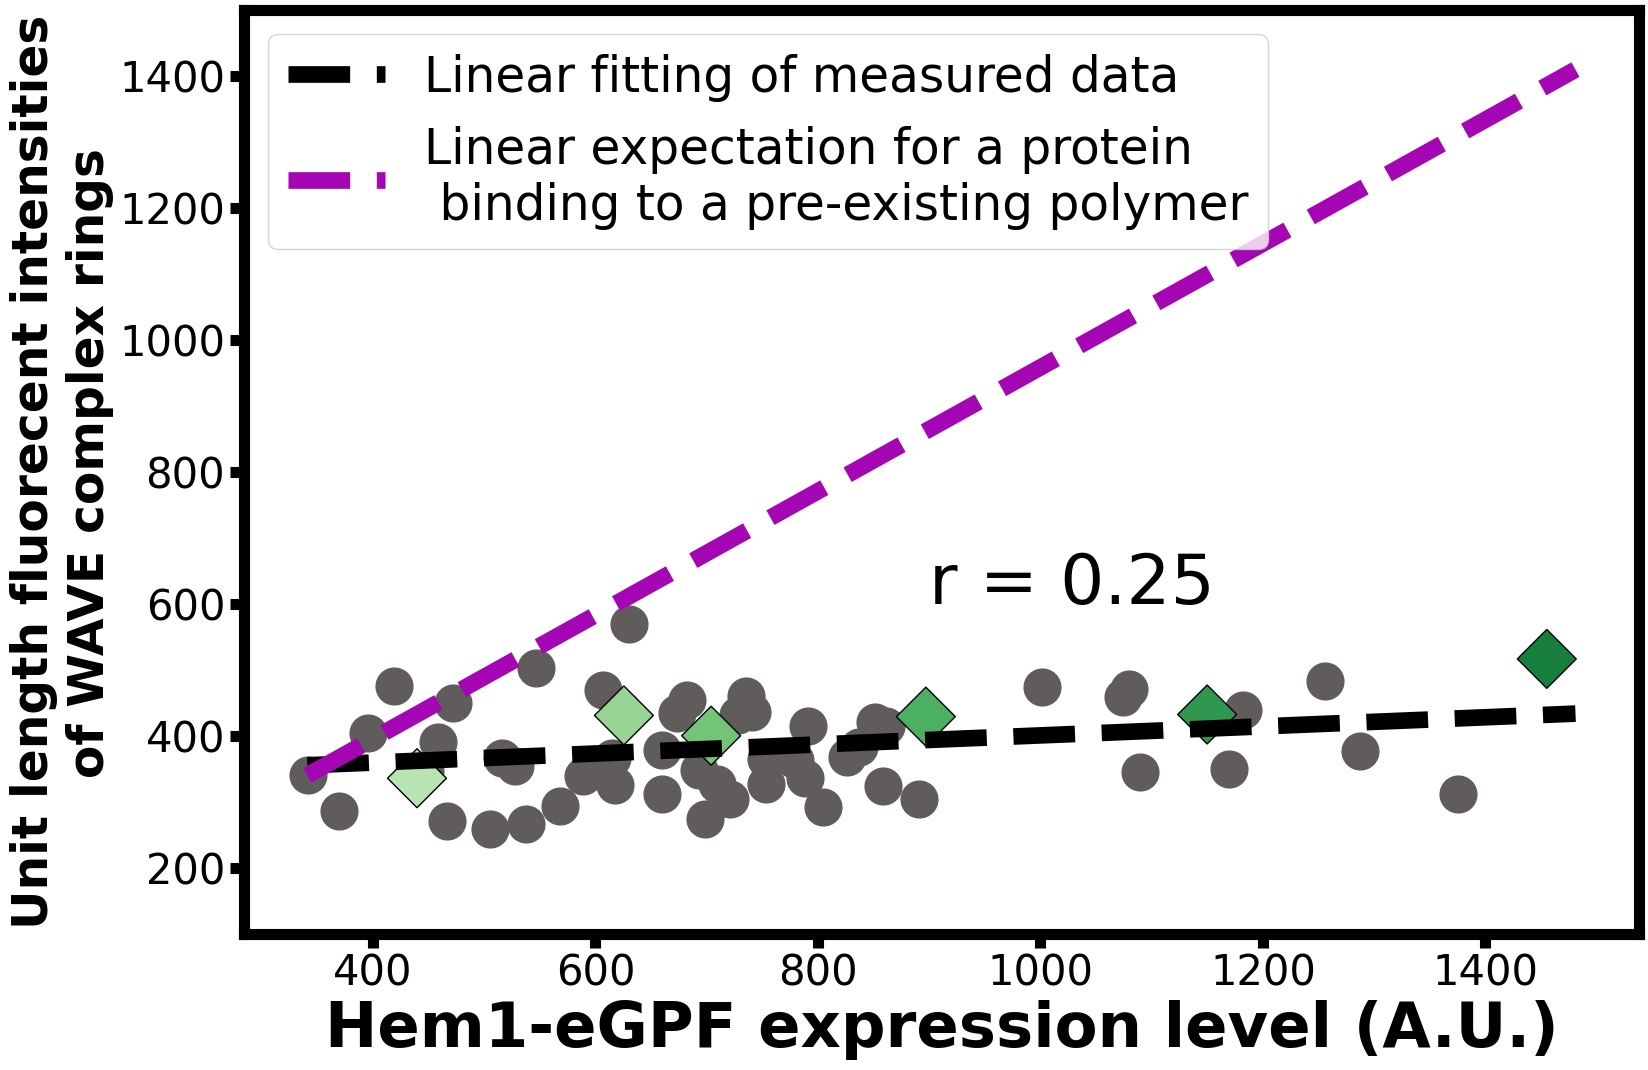

In [27]:
fig,ax  = plt.subplots(figsize = (18,12))
plt.scatter(exp_level['exp_level'],rings_intens['rings_intens'],s = 700,marker = 'o',color = '#605c5c')

plt.ylim(100,1500)
popt = curve_fit(f_linear,exp_level['exp_level'],rings_intens['rings_intens'])[0]
plt.xlabel('Hem1-eGPF expression level (A.U.)',size = 45,fontweight = 'bold')
plt.ylabel('Unit length fluorecent intensities\n of WAVE complex rings',size = 35,fontweight= 'bold')
xn = np.arange(341,1500,30)
# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(8)

# increase tick width
ax.tick_params(width=8,size = 10)

plt.yticks(size = 30)
plt.xticks(size = 30)
plt.plot(xn,f_linear(xn,popt[0],popt[1]),linestyle = '--',color = 'black',label = 'Linear fitting of measured data',lw = 12)
plt.plot(xn,f_linear(xn,0.938,20.02),color = '#a406b3',ls = 'dashed',label = 'Linear expectation for a protein\n binding to a pre-existing polymer',lw = 12)
plt.legend(fontsize = 35,loc = 'upper left')
plt.scatter(select_exp['exp_level'],select_ring['rings_intens'],s = 900,marker = 'D',color = palette,edgecolor = 'black')
plt.text(900,600,'r = 0.25',size = 50)
plt.savefig(PATH + 'result_figures/FigS2D_rings_correlation.png',dpi = 300,bbox_inches = 'tight')

In [28]:
stats.pearsonr(exp_level['exp_level'],rings_intens['rings_intens'])

PearsonRResult(statistic=0.2525569199161612, pvalue=0.055789145862708486)